# MNIST Demo
In this demo, we will show how to train and transform MNIST data. First, we start with imports and some utility functions that will be needed later in the demo.

In [1]:
import os, sys, urllib, warnings, errno, logging, time
import zipfile
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.utils import check_random_state

# Add relative directories so that we have access to ddl library
sys.path.append('.')
sys.path.append('..')
from ddl.base import CompositeDestructor
from ddl.deep import DeepDestructorCV
from ddl.independent import IndependentDensity, IndependentDestructor, IndependentInverseCdf
from ddl.linear import BestLinearReconstructionDestructor
from ddl.univariate import HistogramUnivariateDensity, ScipyUnivariateDensity

# Setup logger for ddl so we can see debug output
logging.basicConfig(stream=sys.stdout)
logging.getLogger('ddl').setLevel(logging.DEBUG)

_DOWNLOAD_DIR = 'data'  # Directory where MNIST data and MAF samples will be downloaded

# Function to load (and download if necessary) the MNIST dataset
def get_mnist_raw():
    def _download_from_other_source():
        # Attempt to download mnist data from another source
        url = 'http://www.cs.cmu.edu/~dinouye/data/mnist-original.mat'
        warnings.warn('Could not download from mldata.org, attempting '
                      'to download from <%s>.' % url)
        file_name = os.path.join(_DOWNLOAD_DIR, 'mldata/mnist-original.mat')
        urllib.request.urlretrieve(url, file_name)
    # Make directory if needed
    try:
        os.makedirs(_DOWNLOAD_DIR)
    except OSError as exc:
        if exc.errno == errno.EEXIST and os.path.isdir(_DOWNLOAD_DIR):
            pass
        else:
            raise
    try:
        data_obj = fetch_mldata('MNIST original', data_home=_DOWNLOAD_DIR)
    except (ConnectionResetError, urllib.error.HTTPError):
        # Retry by downloading data from another source and then loading
        _download_from_other_source()
        data_obj = fetch_mldata('MNIST original', data_home=_DOWNLOAD_DIR)
    return data_obj.data, data_obj.target
        
# Utility functions to transform between uniform and Gaussian supports
def gaussian_to_uniform(Z):
    return scipy.stats.norm.cdf(Z)

def uniform_to_gaussian(U):
    return scipy.stats.norm.ppf(U)

# Image plotting function
def plot_images(X, fig_height=4, title=None):
    n_images = X.shape[0]
    fig, axes = plt.subplots(1, n_images, figsize=(fig_height * n_images, fig_height))
    for x, ax in zip(X, axes):
        ax.imshow(-x.reshape(28, 28), cmap='gray')
        ax.axis('off')
    if title is not None:
        fig.suptitle(title, fontsize=40)

## Load and preprocess MNIST
First, we will load and preprocess the MNIST dataset. Note that we will have to dequantize the MNIST dataset by adding uniform noise and then rescaling so that the values fall on the unit hypercube (or canonical domain).

In [2]:
# Load dataset
print('1. Attempting to load/fetch MNIST data via sklearn.datasets.fetch_mldata.')
X_raw, y = get_mnist_raw()
print('  Done! MNIST data shape = %s, max value = %g' % (str(X_raw.shape), np.max(X_raw)))

# Add uniform noise to dequantize the images
print('2. Dequantizing and normalizing values between 0 and 1.')
random_state = 0
rng = check_random_state(random_state)
X = (X_raw + rng.rand(*X_raw.shape)) / 256.0
print('  Done! After dequantization and normalization: min=%g, max=%g' % (np.min(X), np.max(X)))

# Create train and test splits of the data
print('3. Setting up train, validation and test sizes.')
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
n_test = X_test.shape[0]
n_validation = int(X_train.shape[0] * 0.1)
n_train = X_train.shape[0] - n_validation
print('  Done! train = %d, validation = %d, test = %d' % (n_train, n_validation, n_test))

1. Attempting to load/fetch MNIST data via sklearn.datasets.fetch_mldata.
  Done! MNIST data shape = (70000, 784), max value = 255
2. Dequantizing and normalizing values between 0 and 1.
  Done! After dequantization and normalization: min=4.04763e-11, max=1
3. Setting up train, validation and test sizes.
  Done! train = 56700, validation = 6300, test = 7000


## Train deep copula model
We will now define and train a deep copula model on the MNIST train dataset. First, we will define the deep copula destructor:

In [3]:
# Create deep copula destructor
deep_copula_destructor = DeepDestructorCV(
    init_destructor=CompositeDestructor([
        IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
            bins=256, bounds=[0, 1], alpha=1
        )))
    ]),
    canonical_destructor=CompositeDestructor([
        IndependentDestructor(IndependentDensity(HistogramUnivariateDensity(
            bins=40, bounds=[0, 1], alpha=100
        ))),
        IndependentInverseCdf(),
        BestLinearReconstructionDestructor(
            linear_estimator=PCA(), destructor=IndependentDestructor(),
        )
    ]),
    # Setup copula destructor to just use a single train/validation split and do not refit
    cv=[(np.arange(n_train), n_train + np.arange(n_validation))], refit=False,
    stop_tol=0.001, random_state=random_state,
)
print(deep_copula_destructor)

DeepDestructorCV(canonical_destructor=CompositeDestructor(destructors=[IndependentDestructor(independent_density=IndependentDensity(univariate_estimators=HistogramUnivariateDensity(alpha=100, bins=40, bounds=[0, 1]))), IndependentInverseCdf(), BestLinearReconstructionDestructor(destructor=IndependentDestructor(indep...None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))],
          random_state=None),
         cv=[(array([    0,     1, ..., 56698, 56699]), array([56700, 56701, ..., 62998, 62999]))],
         init_destructor=CompositeDestructor(destructors=[IndependentDestructor(independent_density=IndependentDensity(univariate_estimators=HistogramUnivariateDensity(alpha=1, bins=256, bounds=[0, 1])))],
          random_state=None),
         log_prefix='', max_canonical_destructors=None, n_extend=1,
         random_state=0, refit=False, silent=False, stop_tol=0.001)


Now we will actually train the deep copula destructor.  Note that this may take some time (on MacBook Pro, this took about 5 minutes or about 300 seconds).

In [4]:
# Train and transform destructor
start_time = time.time()
deep_copula_destructor.fit(X_train)
print('Wall-clock time for training: %g s' % (time.time() - start_time))

DEBUG:ddl.deep:(CV sp=1, L=1) Scores: train=3429.15 val=3427.61
DEBUG:ddl.deep:(CV sp=1, L=2) Scores: train=135.41 val=129.448
DEBUG:ddl.deep:(CV sp=1, L=2) Relative diff=0.0377663
DEBUG:ddl.deep:(CV sp=1, L=3) Scores: train=29.5752 val=29.1621
DEBUG:ddl.deep:(CV sp=1, L=3) Relative diff=0.00819837
DEBUG:ddl.deep:(CV sp=1, L=4) Scores: train=2.31424 val=2.09258
DEBUG:ddl.deep:(CV sp=1, L=4) Relative diff=0.000583507
DEBUG:ddl.deep:Fitting extra needed layers
DEBUG:ddl.deep:Already done fitting cv=0 deep destructor
Wall-clock time for training: 254.082 s


## Comparing MNIST samples to other methods
In this part, we will compare MNIST samples from the models in the Masked Autoregressive Flow (MAF) paper and samples from our destructor.
We have precomputed and saved samples from the MAF models so we just load them directly.

Note that none of these models use the structure of images to learn their models (e.g. smoothness of images).
Thus, all these models will not be state-of-the-art for image generation.
In addition, these models optimize for test log-likelihood (i.e. the density task) rather sample generation as is the case for GANs or similar models.

First we will download the MAF data samples if not already downloaded.

In [5]:
# Show samples from models in MAF paper
# Attempt to download mnist data from another source
maf_folder = os.path.join(_DOWNLOAD_DIR, 'model_samples')
if not os.path.isdir(maf_folder):
    url = 'http://www.cs.cmu.edu/~dinouye/data/maf_paper_model_samples.zip'
    filename = os.path.join(_DOWNLOAD_DIR, 'maf_paper_model_samples.zip')
    print('Downloading MAF data to %s' % os.path.abspath(filename))
    urllib.request.urlretrieve(url, filename)

    print('Extracting MAF data')
    zip_ref = zipfile.ZipFile(filename, 'r')
    zip_ref.extractall(_DOWNLOAD_DIR)
    zip_ref.close()
else:
    print('MAF data already downloaded')

MAF data already downloaded


Next we will train a transformation that will invert the logit preprocessing transformation that was applied to the pixel values in the MAF paper.
We will use this transformation to project samples from the MAF models back to pixel space so that we can visualize the samples.

In [6]:
# Define inverse logit destructor (copied from scripts/icml_2018_experiment.py)
#  to invert samples from MAF paper where the samples are in logit space
alpha = 1.0e-6
mnist_inverse_logit = CompositeDestructor([
    IndependentDestructor(IndependentDensity(ScipyUnivariateDensity(
        scipy_rv=scipy.stats.logistic, scipy_fit_kwargs=dict(floc=0, fscale=1)
    ))),
    IndependentDestructor(IndependentDensity(ScipyUnivariateDensity(
        scipy_rv=scipy.stats.uniform, scipy_fit_kwargs=dict(floc=alpha, fscale=1 - 2 * alpha)
    )))
])
mnist_inverse_logit.fit(X_train[:1, :])

CompositeDestructor(destructors=[IndependentDestructor(independent_density=IndependentDensity(univariate_estimators=ScipyUnivariateDensity(scipy_fit_kwargs={'floc': 0, 'fscale': 1},
            scipy_rv=<scipy.stats._continuous_distns.logistic_gen object at 0x180edf6b00>))), IndependentDestructor(independent_density=In...99998},
            scipy_rv=<scipy.stats._continuous_distns.uniform_gen object at 0x180ee2f9b0>)))],
          random_state=None)

Finally, we show samples from the MAF models and from our trained destructor.

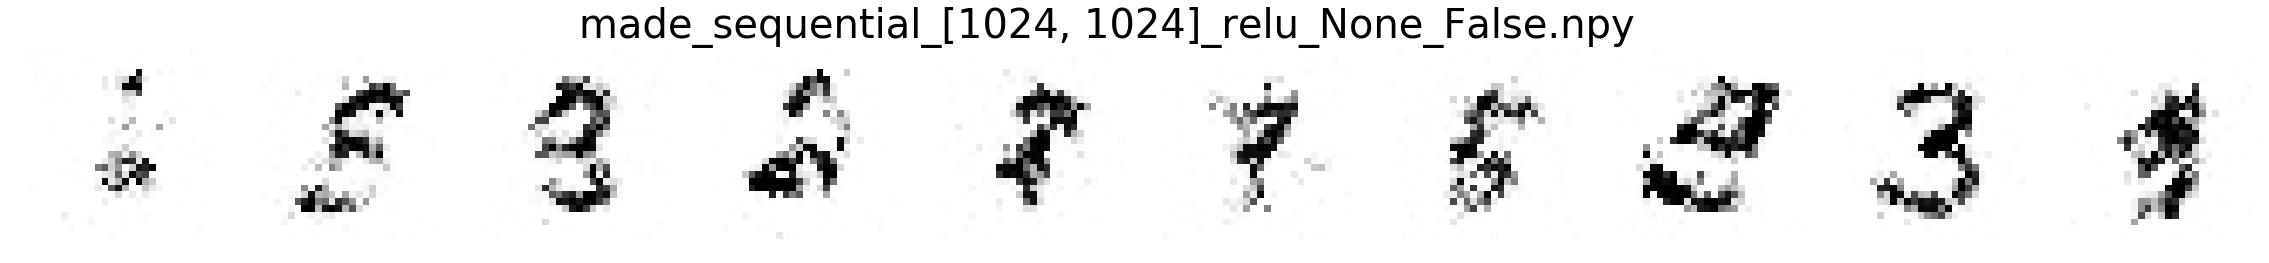

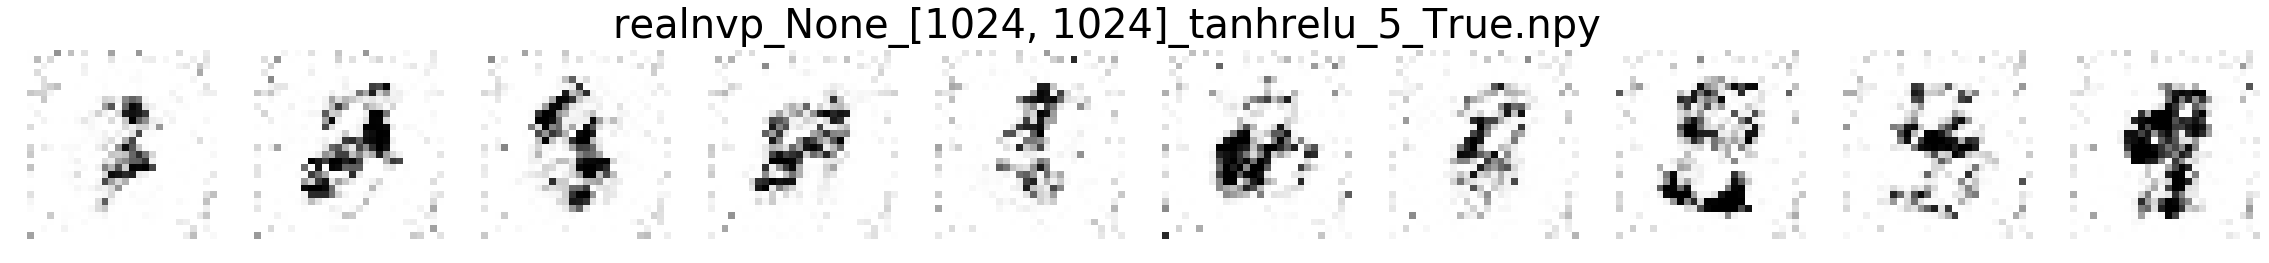

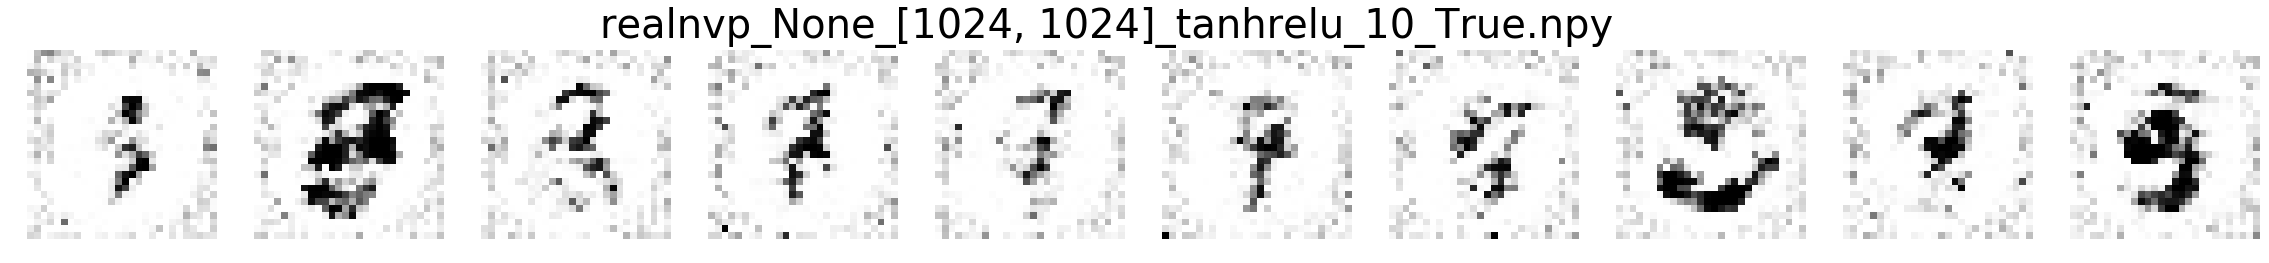

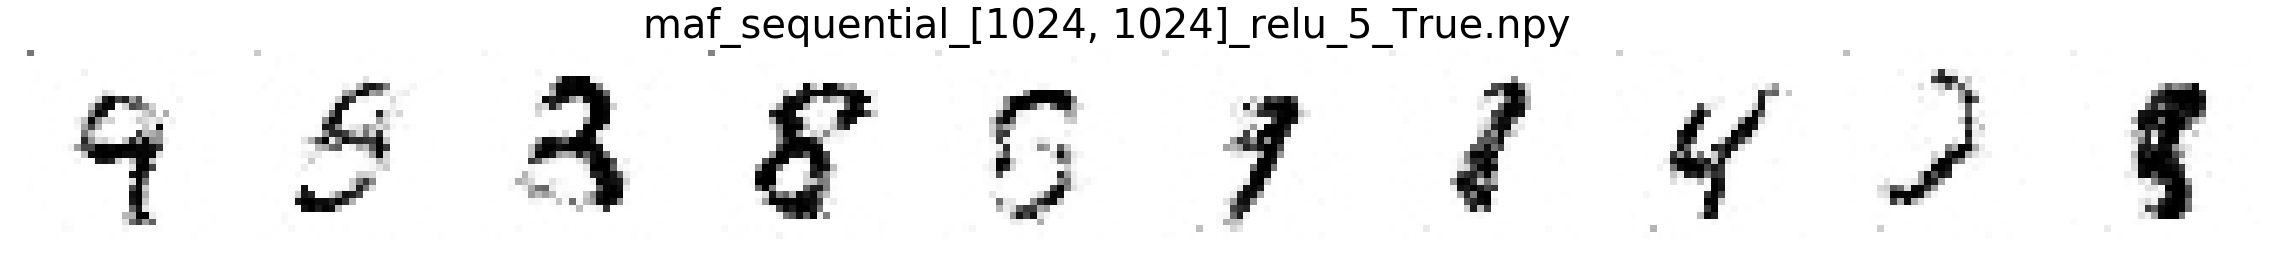

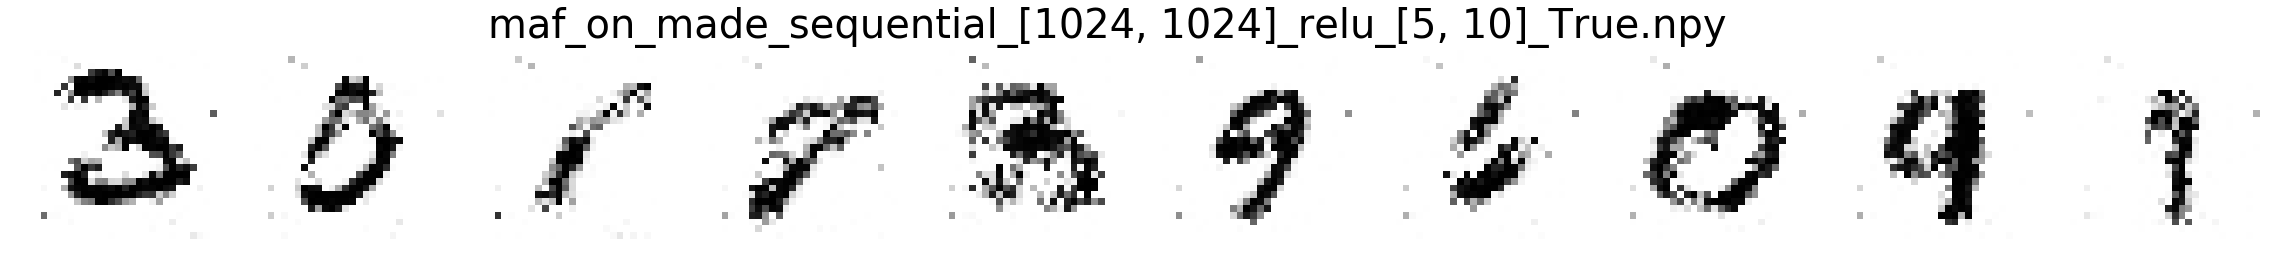

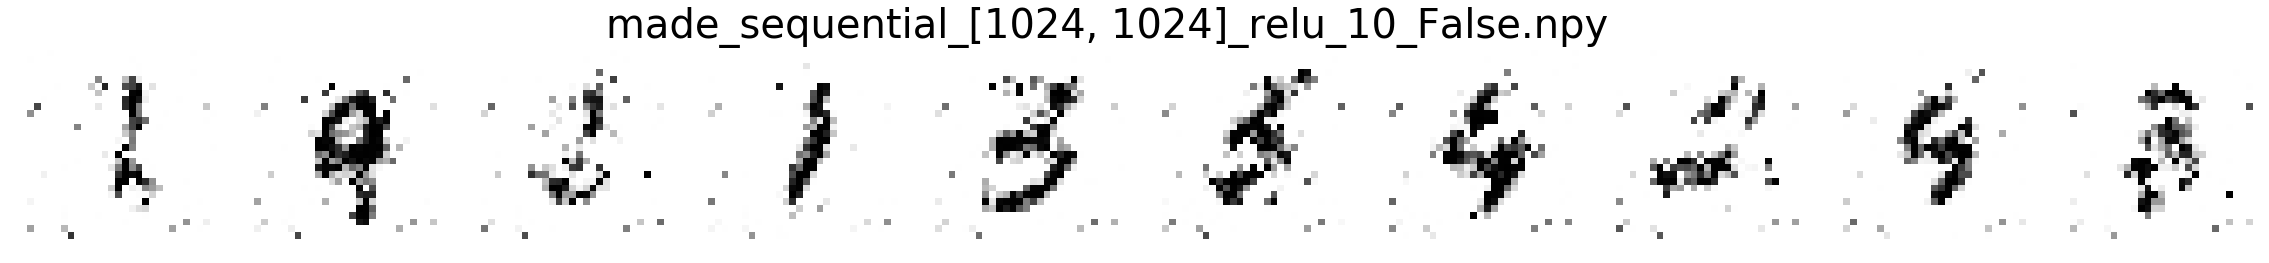

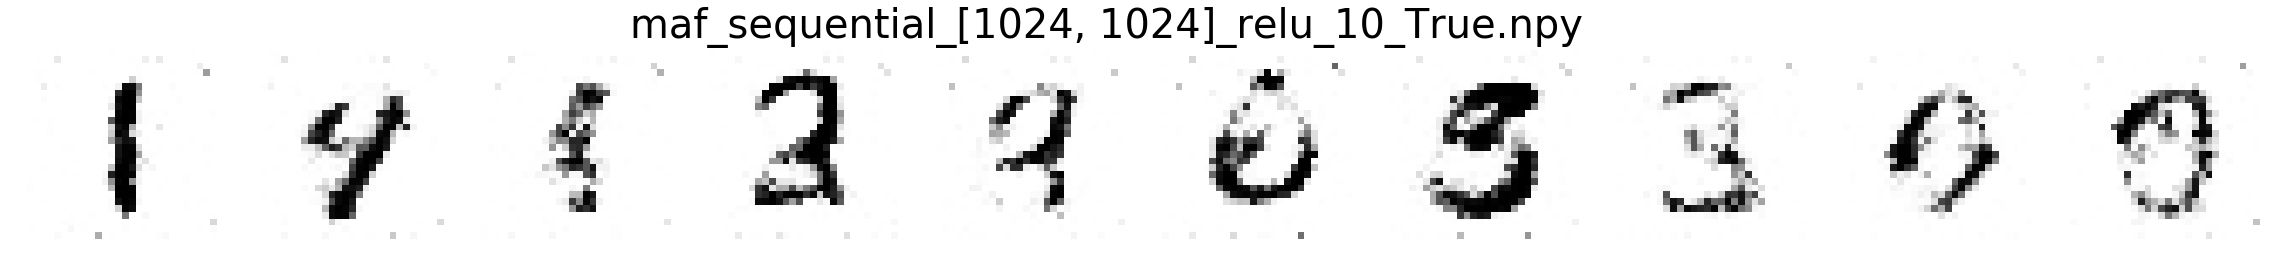

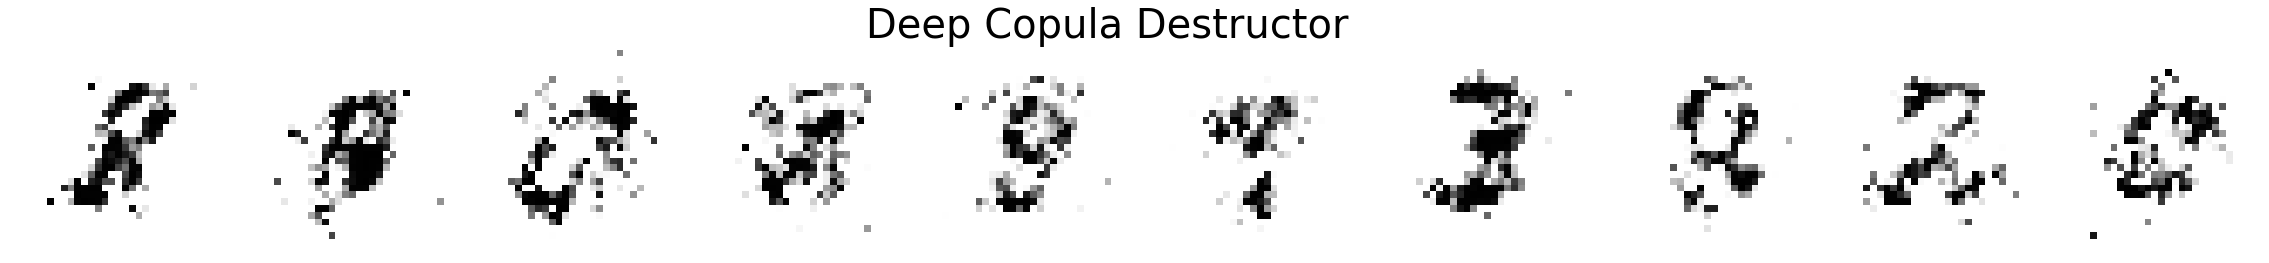

In [7]:
n_images = 10
for filename in os.listdir(maf_folder):
    filepath = os.path.join(maf_folder, filename)
    X_sample_logit = np.load(filepath)
    with warnings.catch_warnings():
        # Ignore data conversion warnings near boundary
        warnings.simplefilter('ignore')
        X_sample = mnist_inverse_logit.transform(X_sample_logit)
    plot_images(X_sample[:n_images, :], title=filename)
    
# Show our samples
with warnings.catch_warnings():
    # Ignore n_features_ warning
    warnings.simplefilter('ignore')
    X_sample = deep_copula_destructor.sample(n_samples=n_images, random_state=0)
plot_images(X_sample, title='Deep Copula Destructor')
plt.show()

## Exploring the discovered MNIST latent space
Now we will explore the discovered MNIST latent space.
First, we project the data into the latent space.
Because destructors project onto the unit hypercube, we label the transformed data U_train and U_test.
We also project onto the unbounded space by applying the standard normal inverse CDF independently to each coordinate. 
This unbounded latent space is likely more suited for linear interpolation than the bounded unit hypercube latent space.

In [8]:
# Transform data into uniform latent space on unit hypercube
U_train = deep_copula_destructor.transform(X_train)
U_test = deep_copula_destructor.transform(X_test)

# Project uniform data onto unbounded space via Gaussian inverse cdf
Z_train = uniform_to_gaussian(U_train)
Z_test = uniform_to_gaussian(U_test)

Now we will interpolate between two random images.
We compare linear interpolation in the raw pixel space and linear interpolation in the latent space.
Notice that the latent space is more intuitive and generally includes darker pixels at all times rather than a mixed gray color as is the case for linear interpolation in the pixel space.
Also, note that previous methods such as MADE or MAF do not have an explicit latent space representation so it is not possible to directly compare.

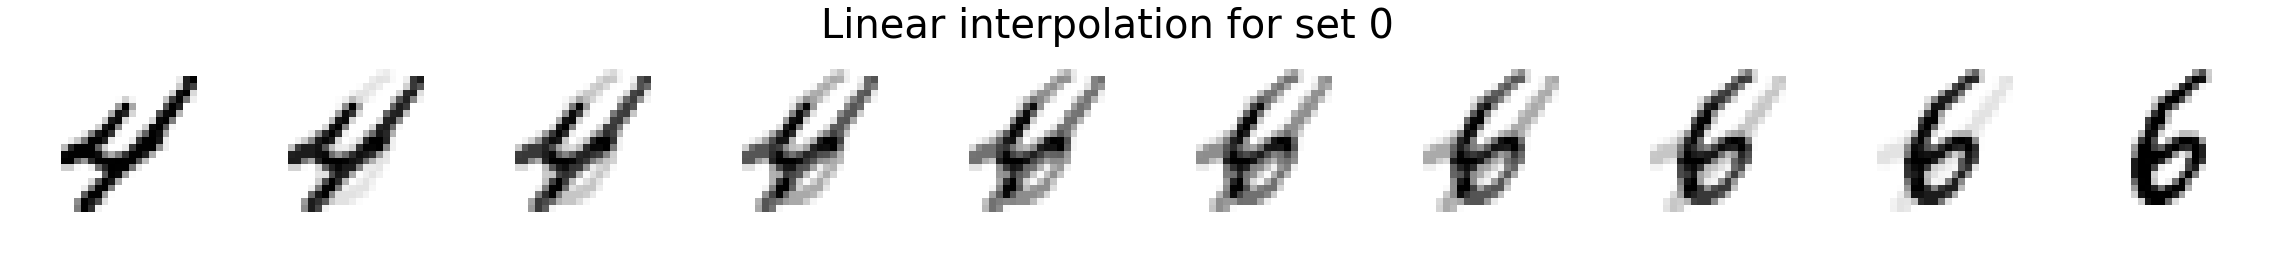

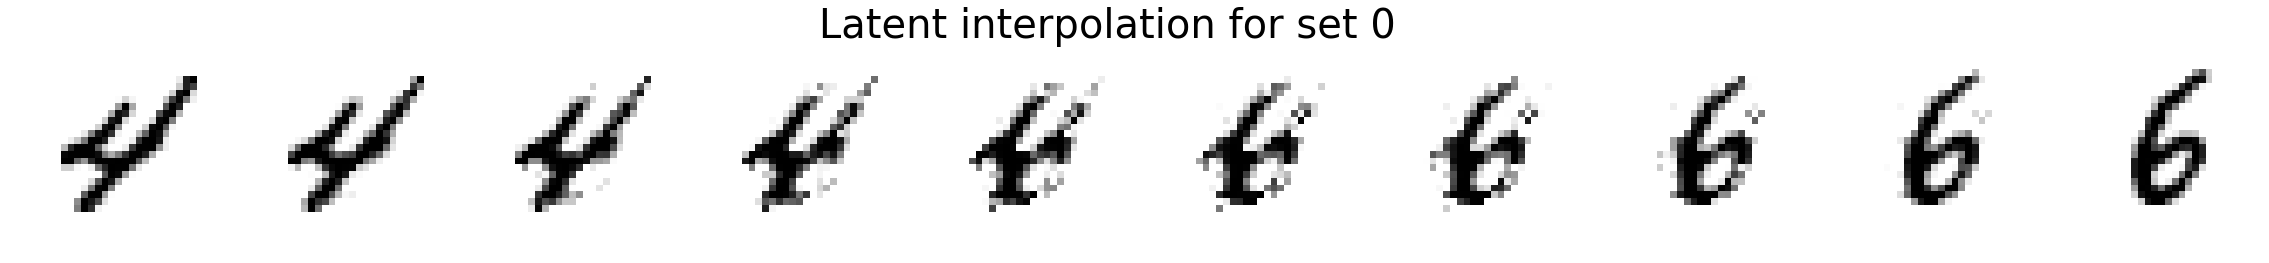

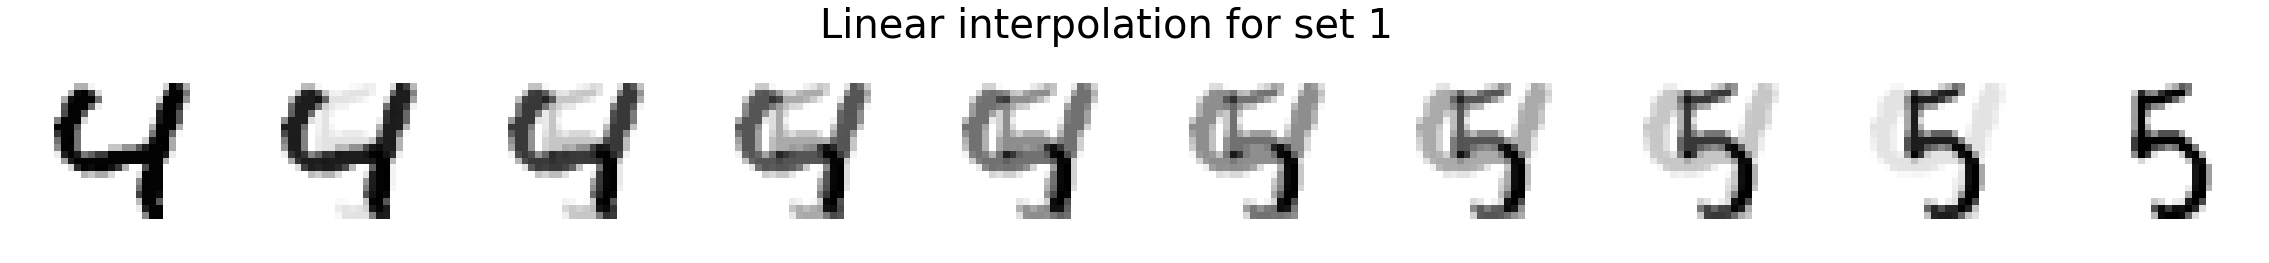

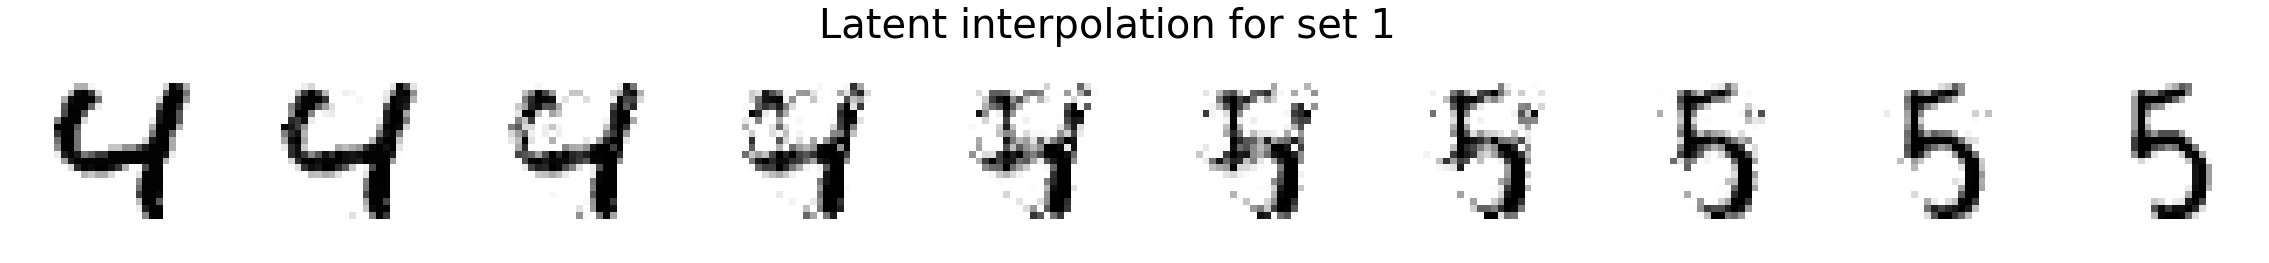

In [9]:
# Show interpolations between two images in raw pixel space and latent space
rng = check_random_state(1)
perm = rng.permutation(U_train.shape[0])
for i in range(2):
    rand_ind = [perm[i*2], perm[i*2 + 1]]
    weights = np.linspace(0, 1, n_images)
    
    # Linear interpolation in pixel space
    X_interp_linear = np.outer(weights, X_train[rand_ind[0], :]) + np.outer(1 - weights, X_train[rand_ind[1], :])
    
    # Interpolation in latent Gaussian unbounded space
    Z_interp = np.outer(weights, Z_train[rand_ind[0], :]) + np.outer(1 - weights, Z_train[rand_ind[1], :])
    U_interp = gaussian_to_uniform(Z_interp)  # Transform back onto unit hypercube
    X_interp = deep_copula_destructor.inverse_transform(U_interp)  # Transform to pixel space
    
    plot_images(X_interp_linear, title='Linear interpolation for set %d' % i)
    plot_images(X_interp, title='Latent interpolation for set %d' % i)
plt.show()